# Basic Setup

In [ ]:
import warnings
import torch
import torchvision
from torch import nn
import os
import requests
import zipfile
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time

## Downloading the data

In [ ]:
def download_extract(data_url, data_dir):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    zip_path = os.path.join(data_dir, 'pokemon.zip')
    if not os.path.exists(zip_path):
        response = requests.get(data_url)
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
    return data_dir

In [ ]:
data_url = 'http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip'
data_dir = download_extract(data_url, 'data')

# Configurations

All these values are as mentioned in the paper

In [ ]:
BATCH_SIZE = 128
WIDTH, HEIGHT = 64, 64
IMG_CHANNELS = 3
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEAK_SLOPE = 0.2
NOISE_DIM = 100
LEARNING_RATE = 2e-4
MOMENTUM = 0.5
FEATURES_G = 64
FEATURES_D = 64

In [ ]:
DEVICE

device(type='cuda')

# Loading the Dataset

In [ ]:
pokemon = torchvision.datasets.ImageFolder(data_dir)

## Transformations

In [ ]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
pokemon.transform = transformer

## Dataloader

In [ ]:
dataloader = DataLoader(pokemon, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Displaying Images

In [ ]:
def show_images(images, num_rows, num_cols, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].imshow(images[i * num_cols + j])
            axes[i, j].axes.get_xaxis().set_visible(False)
            axes[i, j].axes.get_yaxis().set_visible(False)
    return axes

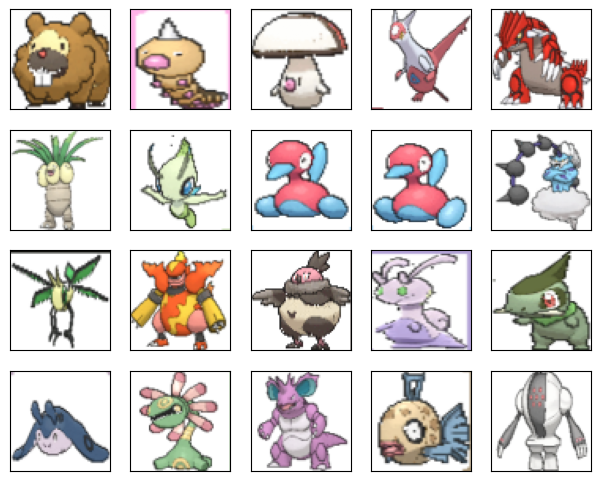

In [ ]:
warnings.filterwarnings('ignore')
for X, y in dataloader:
    imgs = X[:20].permute(0, 2, 3, 1) / 2 + 0.5
    show_images(imgs, 4, 5)
    break

# Creating the Model

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, f_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input is (Noise x 1 x 1)
            self.conv_T_block(NOISE_DIM, f_g * 8, 4, 1, 0),  # Output: (512, 4, 4)
            self.conv_T_block(f_g * 8, f_g * 4),  # Output: (256, 8, 8)
            self.conv_T_block(f_g * 4, f_g * 2),  # Output: (128, 16, 16)
            self.conv_T_block(f_g * 2, f_g),  # Output: (64, 32, 32)

            # No batch norm in the last layer
            nn.ConvTranspose2d(f_g, IMG_CHANNELS, 4, 2, 1, bias=False), # Output: (3, 64, 64)
            # We use Tanh in the last layer, not ReLU
            nn.Tanh() # Normalises values to the range [-1, 1]
        )

    def conv_T_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )

    def forward(self, X):
        return self.gen(X)

In [ ]:
x = torch.rand((BATCH_SIZE, NOISE_DIM, 1, 1))
G = Generator(FEATURES_G)
print(G(x).shape)

torch.Size([128, 3, 64, 64])


## Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, f_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        # Input: (3, 64, 64)
        self.conv_block(IMG_CHANNELS, f_d),  # Ouput: (64, 32, 32)
        self.conv_block(f_d, f_d * 2), # Ouput: (128, 16, 16)
        self.conv_block(f_d * 2, f_d * 4), # Ouput: (256, 8, 8)
        self.conv_block(f_d * 4, f_d * 8), # Ouput: (512, 4, 4)
        nn.Conv2d(f_d*8, 1, 4, 2, 0)  # Ouput: (1, 1, 1)
    )

  def conv_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(LEAK_SLOPE)
    )

  def forward(self, x):
    return self.disc(x)

In [ ]:
D = Discriminator(FEATURES_D)
x = torch.rand((BATCH_SIZE, IMG_CHANNELS, WIDTH, HEIGHT))
print(D(x).shape)

torch.Size([128, 1, 1, 1])


## Initializinfg Weights

Weights initialized with a normal distribution having mean 0 and standard dev. 0.02

In [ ]:
for weights in D.parameters():
  nn.init.normal_(weights, 0, 0.02)
for weights in G.parameters():
  nn.init.normal_(weights, 0, 0.02)

In [ ]:
G

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(64, 3, kernel

In [ ]:
D

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): 

In [ ]:
# Using the GPU
D = D.to(DEVICE)
G = G.to(DEVICE)

# Training the Model

## Loss Function and Optimizers

Defining the optimizers and the loss

In [ ]:
trainer_hp = {'lr': LEARNING_RATE, 'betas': [MOMENTUM, 0.999]}
trainer_D = torch.optim.Adam(D.parameters(), **trainer_hp)  # Optimizer for Discriminator
trainer_G = torch.optim.Adam(G.parameters(), **trainer_hp)  # Optimizer for Generator
loss = nn.BCEWithLogitsLoss() # Loss Function

# Generator Training

In [ ]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    batch_size = Z.shape[0] # Batch Size = 128
    ones = torch.ones(batch_size, device=DEVICE)  # Tensor of all ones of size (128)
    fake_X = net_G(Z) # Fake data created by generator from the noise
    fake_Y = net_D(fake_X).view(-1) # Probability of data being fake =, D(G(z))
    loss_G = loss(fake_Y, ones) # Loss of generator, on comparing with ideal scenario -> All data is real (Prob = 1)
    trainer_G.zero_grad() # Training the generator
    loss_G.backward()
    trainer_G.step()
    return loss_G.item()

## Discriminator Training

In [ ]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    batch_size = X.shape[0] # Batch Size = 128
    ones = torch.ones(batch_size, device=DEVICE)  # Tensor of all ones of size (128)
    zeros = torch.zeros(batch_size, device=DEVICE) # Tensor of all zeros of size (128)
    real_Y = net_D(X).view(-1)  # Real outputs
    fake_X = net_G(Z) # Fake data created by generator from the noise
    fake_Y = net_D(fake_X.detach()).view(-1)  # Probability of data being fake =, D(G(z))
    loss_D = (loss(real_Y, ones) + loss(fake_Y, zeros)) / 2
    # Loss -> Real data being recognized fake and fake data being recognized as real (Take mean)
    trainer_D.zero_grad() # Training the discriminator
    loss_D.backward()
    trainer_D.step()
    return loss_D.item()

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Final Training

In [ ]:
def train(net_D, net_G):
  for epoch in range(1, EPOCHS + 1):
      tick = time.time() # Start time
      loss_D_sum, loss_G_sum, n = 0.0, 0.0, 0
      for X, _ in dataloader:
          batch_size = X.shape[0]
          Z = torch.normal(0, 1, size=(batch_size, NOISE_DIM, 1, 1)).to(DEVICE) # Random Noise Vector
          X = X.to(DEVICE) # Real image
          loss_D_sum += update_D(X, Z, net_D, net_G, loss, trainer_D) # Loss of Discriminator
          loss_G_sum += update_G(Z, net_D, net_G, loss, trainer_G)  # Loss of Generator
          n += batch_size

      tock = time.time() # End time
      print(f"Epoch {epoch}: Loss Discriminator: {loss_D_sum / n:.3f}, Loss Generator {loss_G_sum / n:.3f}, Time {tock - tick:.2f} sec")

      # Display generated images
      with torch.no_grad():
        # Displaying a batch of 21 images
        Z = torch.normal(0, 1, size=(21, NOISE_DIM, 1, 1), device=DEVICE)
        fake_X = net_G(Z).permute(0, 2, 3, 1).cpu() / 2 + 0.5
        fake_X = fake_X.clamp(0, 1)
        show_images(fake_X, 3, 7) # Displaying the fake data

Epoch 1: Loss Discriminator: 0.002, Loss Generator 0.024, Time 76.29 sec
Epoch 2: Loss Discriminator: 0.001, Loss Generator 0.025, Time 77.04 sec
Epoch 3: Loss Discriminator: 0.001, Loss Generator 0.026, Time 75.47 sec
Epoch 4: Loss Discriminator: 0.001, Loss Generator 0.029, Time 76.09 sec
Epoch 5: Loss Discriminator: 0.001, Loss Generator 0.030, Time 75.92 sec
Epoch 6: Loss Discriminator: 0.001, Loss Generator 0.031, Time 75.84 sec
Epoch 7: Loss Discriminator: 0.001, Loss Generator 0.033, Time 75.60 sec
Epoch 8: Loss Discriminator: 0.001, Loss Generator 0.035, Time 75.78 sec
Epoch 9: Loss Discriminator: 0.001, Loss Generator 0.037, Time 75.89 sec
Epoch 10: Loss Discriminator: 0.001, Loss Generator 0.038, Time 75.68 sec
Epoch 11: Loss Discriminator: 0.001, Loss Generator 0.039, Time 76.14 sec
Epoch 12: Loss Discriminator: 0.001, Loss Generator 0.040, Time 75.75 sec
Epoch 13: Loss Discriminator: 0.001, Loss Generator 0.038, Time 75.75 sec
Epoch 14: Loss Discriminator: 0.000, Loss Gener

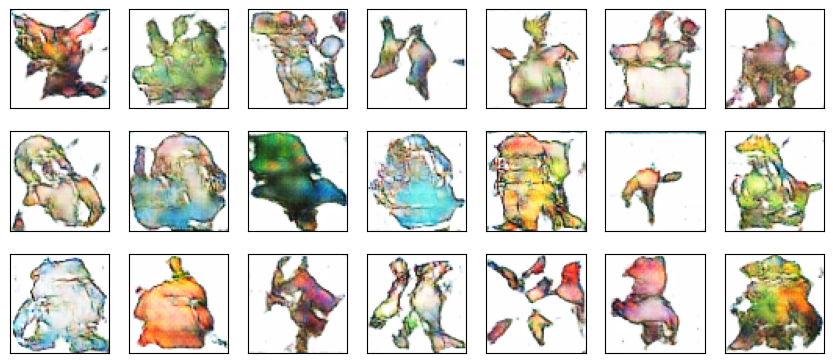

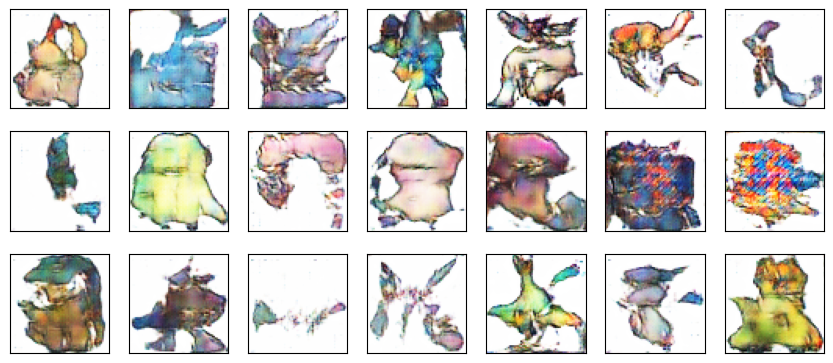

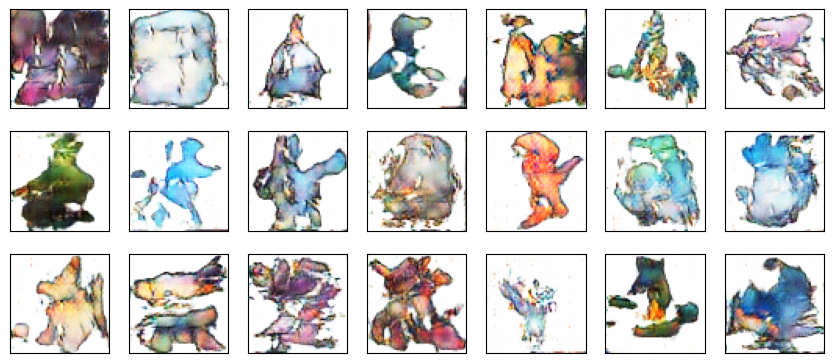

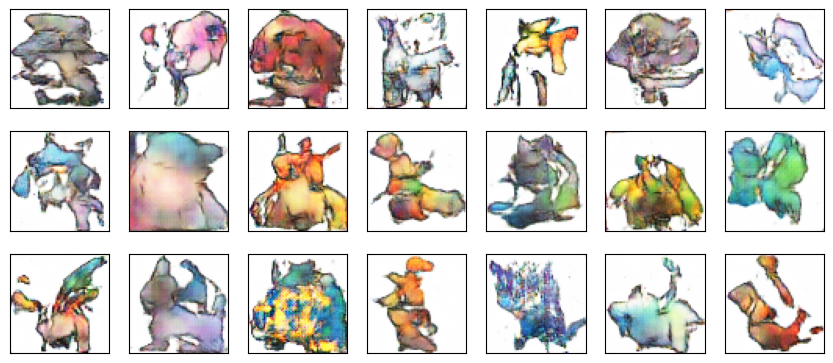

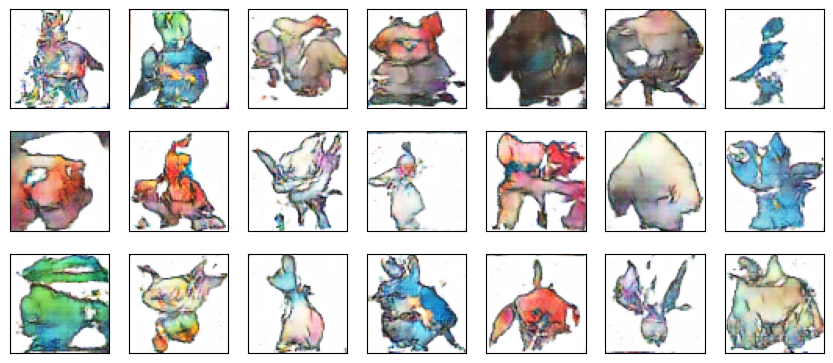

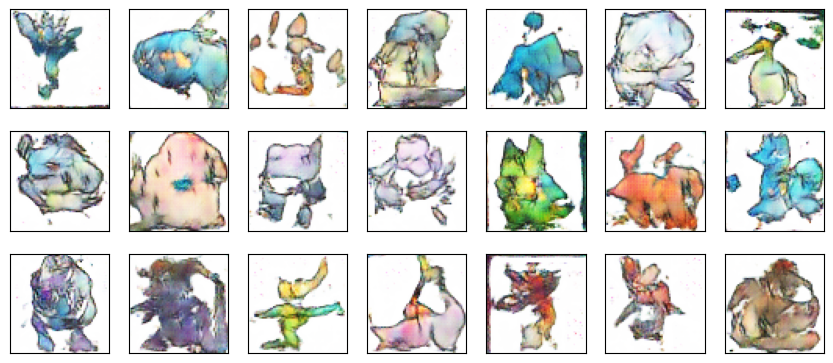

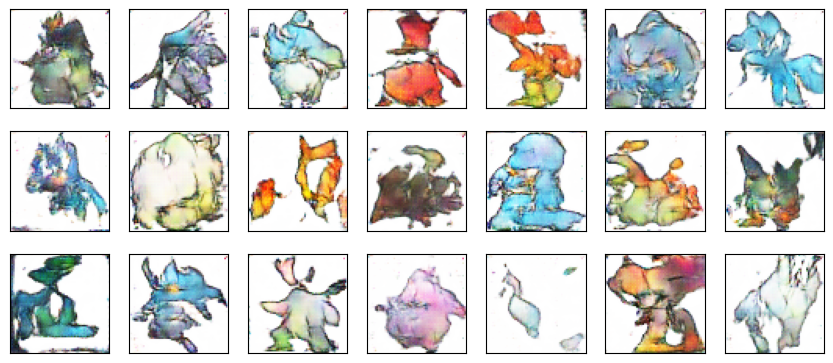

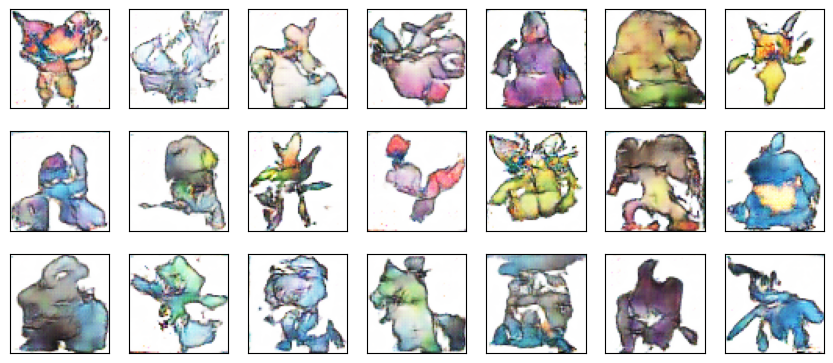

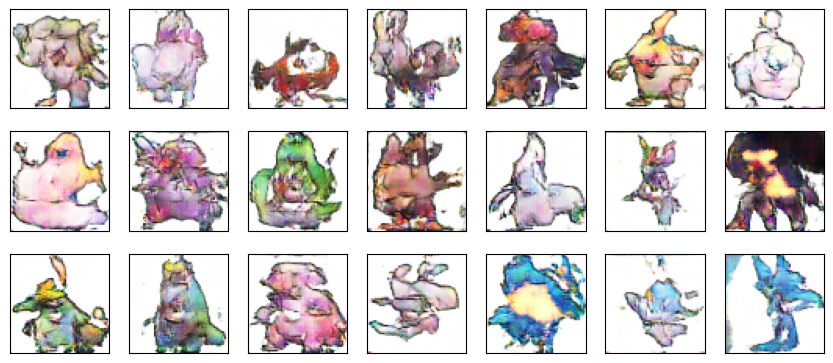

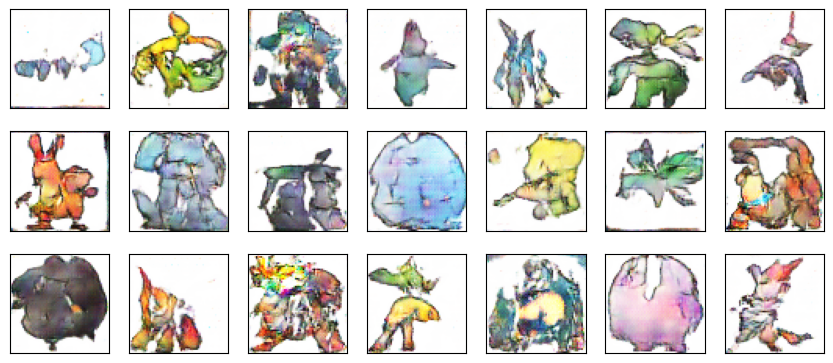

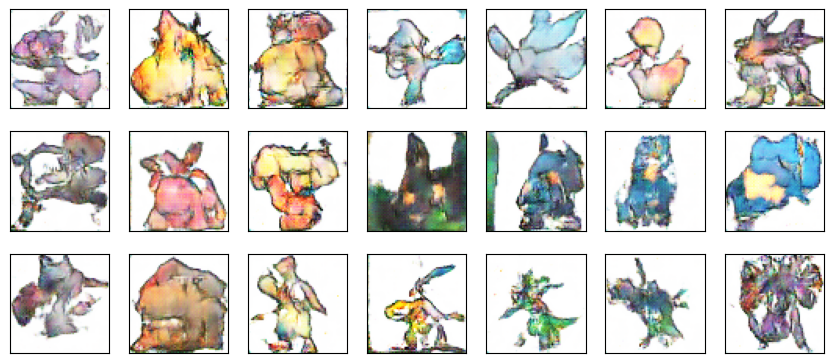

In [ ]:
train(D, G)